# Clustering MD frames

Given thousands of MD snapshots, how do we divide them into clusters and pick representative snapshots for each cluster?

From the clustering, we need to know:
 
 * the centroids
 * weight

## Clustering at a glance

### Kmeans - cluster points in Euclidean space

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

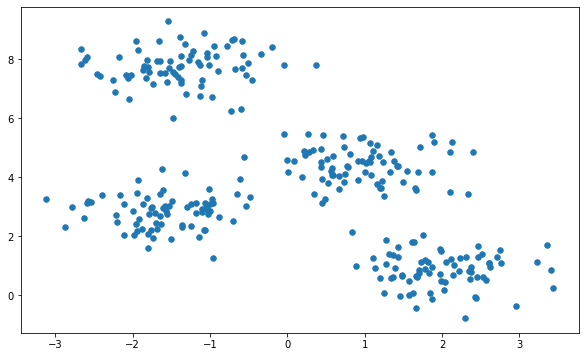

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=30);

In [68]:
# Use kmeans clustering when we have coordinates
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

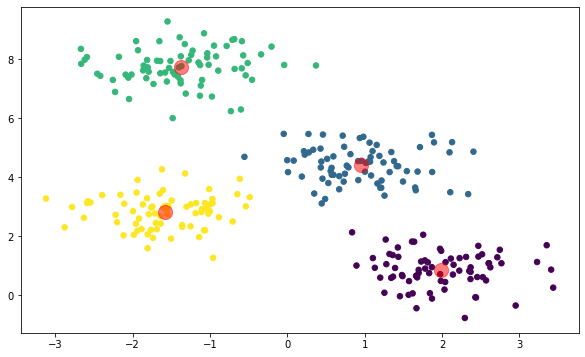

In [69]:
# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

**Conclusions:** Kmeans is very reliable way to cluster points with known coordinates

### Hieracgical clustering - cluster points based on distance matrix

While distance matrix can be derived from points in Euclidean space, points can not be derived from the distance matrix in general. This is because distances do not have to constrain points in 3D space. That is, the dimension that satisfies the distance matrix is unknown. 

In [19]:
# Use hierarchical clustering when we have distance matrix
from sklearn.metrics.pairwise import euclidean_distances
dmatrix = euclidean_distances(X, X)
print(dmatrix)
print(dmatrix.shape)

[[0.         5.73342212 2.98031163 ... 2.43233046 5.67402792 2.69892301]
 [5.73342212 0.         3.4547386  ... 3.41912636 1.82348709 4.67524398]
 [2.98031163 3.4547386  0.         ... 0.91143931 2.80383259 3.76896962]
 ...
 [2.43233046 3.41912636 0.91143931 ... 0.         3.25591848 2.85755514]
 [5.67402792 1.82348709 2.80383259 ... 3.25591848 0.         5.48504557]
 [2.69892301 4.67524398 3.76896962 ... 2.85755514 5.48504557 0.        ]]
(300, 300)


In [70]:
import scipy.spatial.distance as ssd
distArray = ssd.squareform(dmatrix, checks=False) 
import scipy.cluster.hierarchy as hcl
Z = hcl.linkage(distArray)

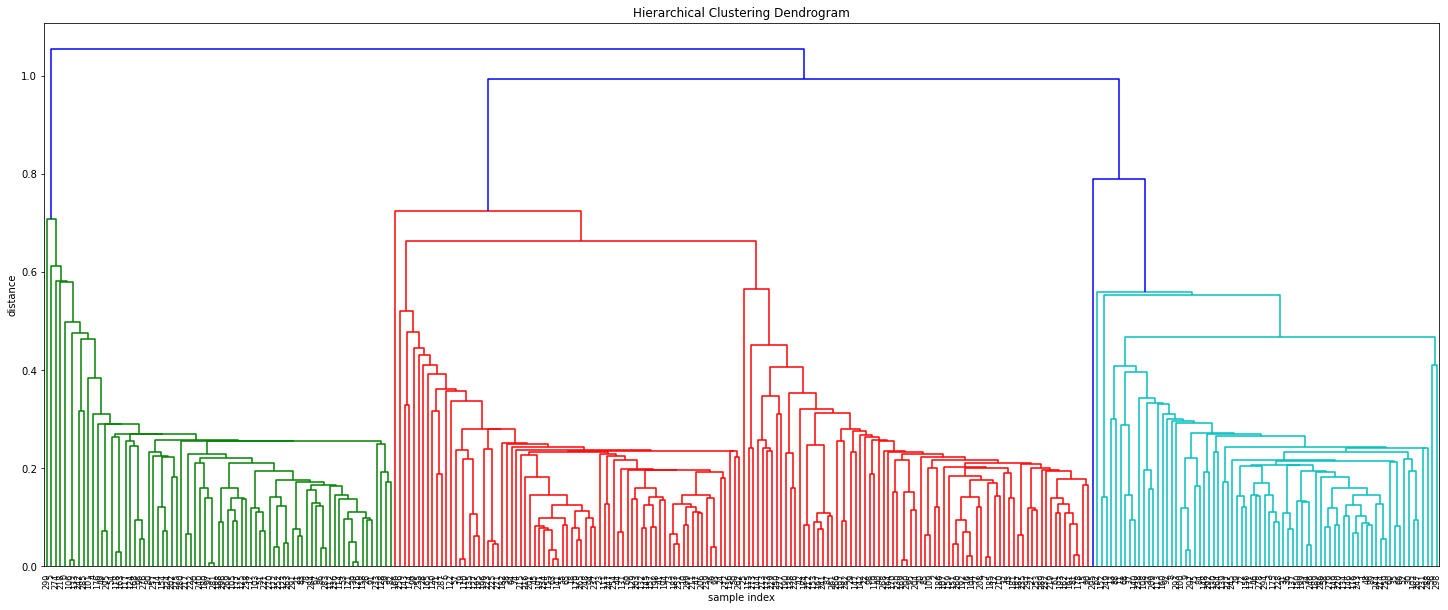

In [64]:
# Visualize dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hcl.dendrogram(
    Z,
    #truncate_mode='lastp',
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [55]:
max_d = 0.65
clusters = hcl.fcluster(Z, max_d, criterion='distance')
clusters

array([1, 6, 4, 6, 1, 1, 3, 4, 6, 6, 3, 6, 4, 6, 1, 4, 4, 1, 3, 3, 1, 1,
       4, 3, 3, 4, 1, 4, 3, 4, 6, 6, 4, 6, 6, 6, 6, 6, 3, 1, 4, 3, 4, 4,
       3, 3, 6, 3, 6, 1, 3, 1, 6, 1, 1, 3, 6, 3, 6, 1, 6, 4, 6, 3, 3, 3,
       6, 1, 6, 3, 4, 3, 6, 3, 3, 6, 3, 4, 1, 6, 1, 4, 1, 1, 6, 4, 1, 4,
       6, 6, 4, 1, 6, 3, 3, 4, 1, 1, 4, 3, 6, 1, 6, 1, 4, 1, 1, 4, 6, 4,
       3, 3, 1, 6, 1, 4, 6, 1, 1, 4, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 6, 3,
       3, 1, 6, 3, 3, 6, 4, 6, 6, 3, 4, 3, 4, 3, 6, 4, 6, 6, 6, 4, 6, 4,
       1, 3, 6, 3, 1, 4, 6, 4, 4, 1, 4, 3, 5, 4, 1, 4, 4, 6, 1, 4, 3, 6,
       1, 1, 4, 3, 1, 4, 3, 3, 4, 4, 4, 4, 1, 6, 4, 3, 4, 4, 3, 3, 3, 4,
       3, 6, 4, 3, 1, 3, 4, 7, 3, 6, 4, 6, 4, 3, 4, 4, 6, 3, 3, 1, 1, 4,
       6, 1, 1, 3, 1, 3, 4, 6, 6, 4, 4, 6, 4, 1, 3, 4, 1, 3, 6, 3, 1, 4,
       1, 6, 6, 6, 6, 3, 3, 6, 4, 3, 1, 4, 3, 3, 3, 1, 1, 6, 4, 4, 3, 1,
       6, 3, 4, 6, 4, 1, 1, 3, 3, 4, 1, 1, 1, 4, 6, 6, 1, 1, 4, 1, 1, 1,
       6, 3, 6, 4, 2, 1, 6, 6, 6, 1, 1, 4, 6, 3], d

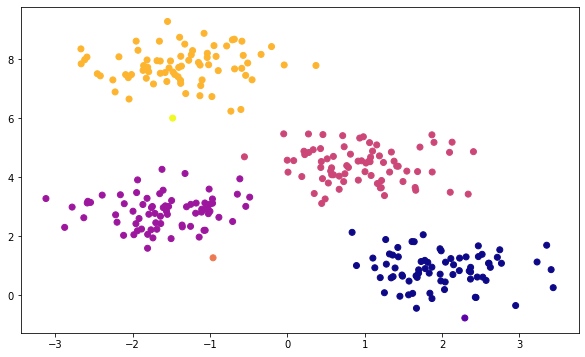

In [62]:
# visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='plasma')  # plot points with cluster dependent colors
plt.show()

We ended up with 6 clusters. Four of them are good, but there are some outliers.

**Conclusions:** Even though we started with good clusters, The hirachical clustering do not produce as good clustering as we hoped.

## Clustering MD frames

MD frames are to be clustered by their structural similarity rather than their absolution position of their centers or certain atom location.

The similarity can be measured in different ways, and therefore clustering techniques will be used. 

### RMSD as distance matrix

If we align two frames (CA atoms only in this work), the RMSD (minimized RMSD after alignment) measures the *average* atom distance, and can be used as an indicator of structure similarity or **distance**.

We have 5000 frames, so the distance would be a $5000\times 5000$ matrix, with the diagonal as 0 and two triagles mirrored to each other. We have to do $\frac{(5000\times 5000 - 5000)}{2} = 12,500,000$ times of alignment.

The alignment of two sets of points here is a 3D rigid transform problem. A python module is available for this task. https://github.com/nghiaho12/rigid_transform_3D/blob/master/rigid_transform_3D.py


### Data prep

1. Extrat atom CA from each frame and make it a pdb file under directory "frames". 
2. Copy 